# Final Project - DMA

Reina Kassem Youssef - 02130269 \
Frédérique Roy - 02188217 \
Yousef Khalil - 02183384 \
Joseph Zahar - 01555368 

In [6]:
# import desired packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import warnings
import holidays
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import NearMiss
import lightgbm as lgb
from tqdm import tqdm
from sklearn.naive_bayes import GaussianNB

In [7]:
# read and load the datasets and define the column names
# yoochoose-buys.dat
buys_df = pd.read_csv('/Users/macbookpro/Desktop/Digital Marketing Analytics/Assignments/Assignment 3/yoochoose-buys.dat', 
                  encoding='Windows-1252', names=['Session ID','Timestamp','Item ID','Price','Quantity'])
# yoochoose-clicks.dat
clicks_df = pd.read_csv('/Users/macbookpro/Desktop/Digital Marketing Analytics/Assignments/Assignment 3/yoochoose-clicks.dat', 
                 encoding='Windows-1252', names=['Session ID','Timestamp','Item ID','Category'])

In [8]:
# check correct read of the data files
clicks_df.head(5)

,Session ID,Timestamp,Item ID,Category
0,1,2014-04-07T10:51:09.277Z,214536502,0
1,1,2014-04-07T10:54:09.868Z,214536500,0
2,1,2014-04-07T10:54:46.998Z,214536506,0
3,1,2014-04-07T10:57:00.306Z,214577561,0
4,2,2014-04-07T13:56:37.614Z,214662742,0


## Data Exploratory Analysis

In [9]:
# Convert timestamp provided from object dtype to timestamp dtype
buys_df['datetime'] = pd.to_datetime(buys_df['Timestamp'])
clicks_df['datetime'] = pd.to_datetime(clicks_df['Timestamp'])
clicks_df = clicks_df.set_index('datetime')
buys_df = buys_df.set_index('datetime')

In [10]:
sessions_buys = set()
for i in buys_df['Session ID']:
    sessions_buys.add(i)

clicks_df['buy?'] = clicks_df['Session ID'].apply(lambda x: 1 if x in sessions_buys else 0)
clicks_df['yes_buy'] = clicks_df['Session ID'].apply(lambda x: 1 if x in sessions_buys else 0)
clicks_df['no_buy'] = clicks_df['Session ID'].apply(lambda x: 0 if x in sessions_buys else 1)

### Temporal Attributes

In [11]:
# Lets use the datetime feature to generate relevant temporal attributes
uk_holidays = holidays.country_holidays('GB')  

def addfeatures(data):
    data['weekday'] = data.index.weekday
    data['hour'] = data.index.hour
    data['day'] = data.index.dayofyear
    data['month'] = data.index.month
    data['holidays name'] = pd.Series(data.index).apply(lambda x: uk_holidays.get(x)).values
    data['holidays name'] = data['holidays name'].fillna('no')
    data.loc[data['holidays name'].str.contains("St. Patrick's Day"), 'holidays name'] = 'no' 
    data['holidays'] = np.where(data['holidays name'] == 'no', 0, 1)
    return data

clicks_df = addfeatures(clicks_df)

#### Weekday

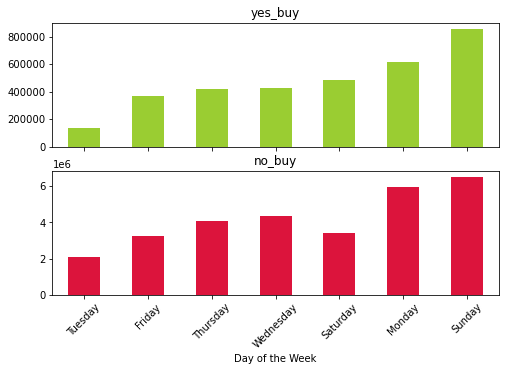

In [12]:
clicks_df_weekday = clicks_df.groupby('weekday')['Session ID'].nunique().sort_values()
clicks_df_weekday_2 = clicks_df.groupby('weekday')['yes_buy','no_buy'].sum().sort_values('yes_buy')

plt.rcParams["figure.figsize"] = [8, 5]
clicks_df_weekday_2.plot(kind='bar',subplots=True,sharex=True, 
                         #title="Number of online sessions per weekday per category",
                         legend=False, color = ['yellowgreen', 'crimson'])
plt.xlabel('Day of the Week')
plt.xticks((5, 0, 3, 2, 1, 4, 6), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'), 
           rotation = 45)
plt.show()

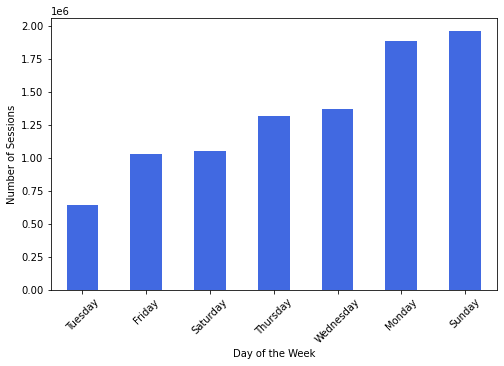

In [13]:
plt.rcParams["figure.figsize"] = [8, 5]
clicks_df_weekday.plot.bar(color = 'royalblue')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Sessions')
plt.xticks((5, 0, 4, 3, 1, 2, 6), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'), 
           rotation = 45)
#plt.title("Number of online sessions per weekday")
plt.show()

#### Hourly

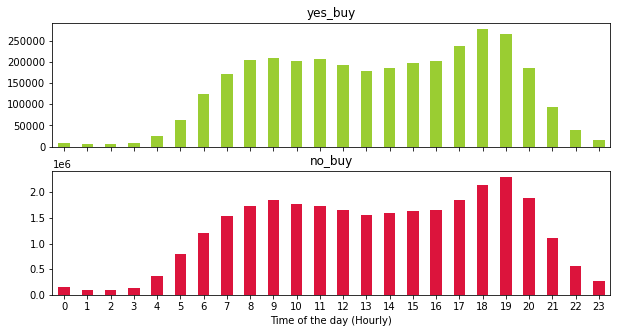

In [14]:
clicks_df_hour = clicks_df.groupby('hour')['Session ID'].nunique()
clicks_df_hour_2 = clicks_df.groupby('hour')['yes_buy','no_buy'].sum()


plt.rcParams["figure.figsize"] = [10, 5]
clicks_df_hour_2.plot(kind='bar',subplots=True,sharex=True, 
                         #title="Number of online sessions per hour per category",
                         legend=False, color = ['yellowgreen', 'crimson'])
plt.xticks(rotation = 0)
plt.xlabel('Time of the day (Hourly)')
plt.show()

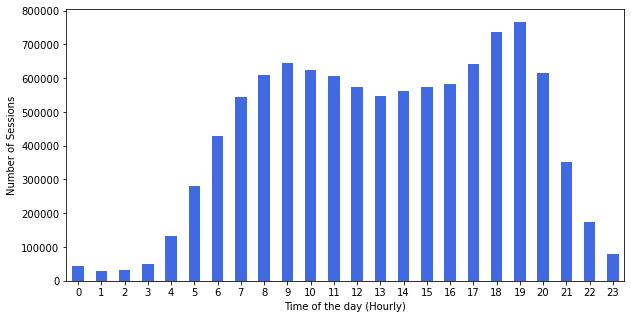

In [15]:
plt.rcParams["figure.figsize"] = [10, 5]
clicks_df_hour.plot.bar(color = 'royalblue')
plt.xticks(rotation = 0)
plt.xlabel('Time of the day (Hourly)')
plt.ylabel('Number of Sessions')
#plt.title('Number of online sessions per hour')
plt.show()

#### Monthly

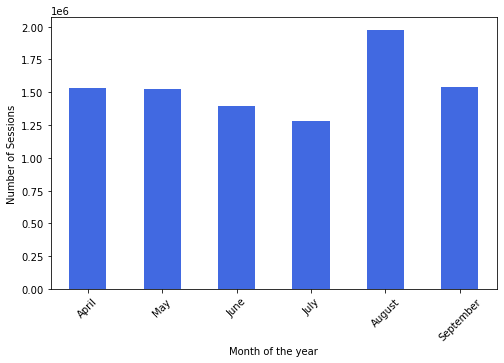

In [16]:
clicks_df_month = clicks_df.groupby('month')['Session ID'].nunique()
plt.rcParams["figure.figsize"] = [8, 5]
clicks_df_month.plot.bar(color = 'royalblue')
plt.xticks(rotation = 0)
plt.xlabel('Month of the year')
plt.ylabel('Number of Sessions')
plt.xticks((0,1,2,3,4,5), ('April', 'May', 'June', 'July', 'August', 'September'), rotation = 45)
#plt.title('Number of online sessions per month')
plt.show()

### Statistical Attributes

#### Session Duration

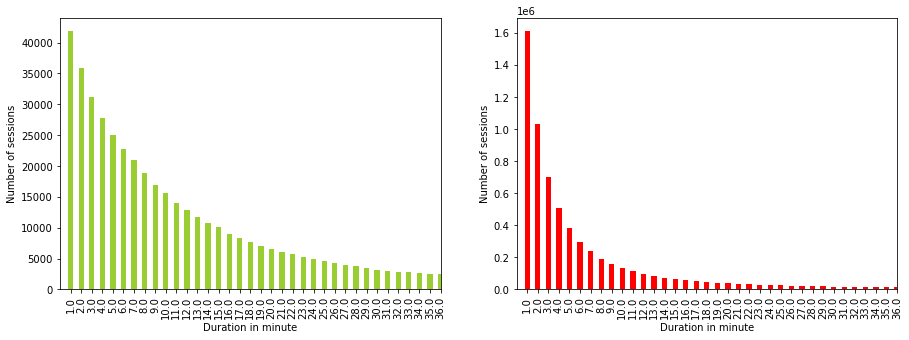

In [17]:
clicks_df_duration_no = clicks_df[clicks_df['buy?'] == 0]
clicks_df_duration_yes = clicks_df[clicks_df['buy?'] == 1]
figure, axes = plt.subplots(1, 2, figsize = (15,5))

clicks_df_duration_no = clicks_df_duration_no.reset_index()
clicks_df_duration_no = clicks_df_duration_no.groupby('Session ID')['datetime'].agg(['first','last'])
clicks_df_duration_no['duration'] = round((clicks_df_duration_no['last'] - clicks_df_duration_no['first']).dt.total_seconds()/ 60.0,0)
clicks_df_duration_no = clicks_df_duration_no[clicks_df_duration_no.duration >= 1]
clicks_df_duration_no_f = clicks_df_duration_no.groupby('duration').count()
clicks_df_duration_no_f = clicks_df_duration_no_f.loc[:, 'first']

clicks_df_duration_yes = clicks_df_duration_yes.reset_index()
clicks_df_duration_yes = clicks_df_duration_yes.groupby('Session ID')['datetime'].agg(['first','last'])
clicks_df_duration_yes['duration'] = round((clicks_df_duration_yes['last'] - clicks_df_duration_yes['first']).dt.total_seconds()/ 60.0,0)
clicks_df_duration_yes = clicks_df_duration_yes[clicks_df_duration_yes.duration >= 1]
clicks_df_duration_yes_f = clicks_df_duration_yes.groupby('duration').count()
clicks_df_duration_yes_f = clicks_df_duration_yes_f.loc[:, 'first']

clicks_df_duration_yes_f.plot.bar(color = 'yellowgreen',ax = axes[0])
clicks_df_duration_no_f.plot.bar(color = 'red', ax = axes[1])

axes[0].set_xlim([-1, 35])
axes[1].set_xlim([-1, 35])
axes[0].set_xlabel('Duration in minute')
axes[1].set_xlabel('Duration in minute')
axes[0].set_ylabel('Number of sessions')
axes[1].set_ylabel('Number of sessions')
#axes[0].set_title('Number of sessions that lead to a purchase')
#axes[1].set_title('Number of sessions that lead to no purchase')

plt.show()

#### Class Balance (distinct sessions)

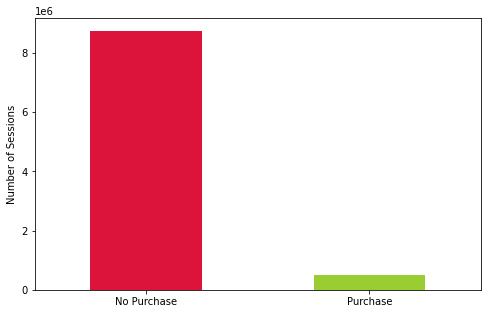

Approximately, 5.83% of the given sessions lead to a buy event. We have a clear imbalance between both classes.


In [18]:
plt.figure(figsize=(8, 5))
clicks_df_classes = clicks_df.groupby('buy?')['Session ID'].nunique()
clicks_df_classes.plot.bar(color = ['crimson','yellowgreen'])
plt.ylabel('Number of Sessions')
plt.xlabel('')
plt.xticks((0,1), ('No Purchase', 'Purchase'), rotation = 0)
plt.show()

print(f'Approximately, {round(clicks_df_classes[1]*100/clicks_df_classes[0],2)}% of the given sessions lead to a buy event. We have a clear imbalance between both classes.')

#### Total items viewed per session

In [19]:
clicks_df_tviews = clicks_df.groupby('Session ID')['Item ID'].count()
clicks_df_tviews = clicks_df_tviews.reset_index()
clicks_df_tviews['buys?'] = clicks_df_tviews['Session ID'].apply(lambda x: 1 if x in sessions_buys else 0)
clicks_df_tviews = clicks_df_tviews[clicks_df_tviews['Item ID'] > 1]
clicks_df_tviews_avg = clicks_df_tviews.groupby('buys?')['Item ID'].mean()
print(f'On average, sessions that lead to a purchase record {round(clicks_df_tviews_avg[1],2)} clicks, while sessions with no purchases records {round(clicks_df_tviews_avg[0],2)} clicks in total')

On average, sessions that lead to a purchase record 6.74 clicks, while sessions with no purchases records 3.79 clicks in total


#### Unique items viewed per session

In [20]:
clicks_df_uviews = clicks_df.groupby('Session ID')['Item ID'].nunique()
clicks_df_uviews = clicks_df_uviews.reset_index()
clicks_df_uviews['buys?'] = clicks_df_uviews['Session ID'].apply(lambda x: 1 if x in sessions_buys else 0)
clicks_df_uviews_avg = clicks_df_uviews.groupby('buys?')['Item ID'].mean()
print(f'On average, sessions that lead to a purchase record {round(clicks_df_uviews_avg[1],2)} clicks, while sessions with no purchases records {round(clicks_df_uviews_avg[0],2)} clicks in total')

On average, sessions that lead to a purchase record 4.54 clicks, while sessions with no purchases records 2.78 clicks in total


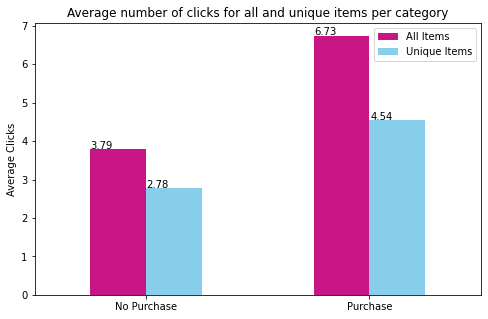

In [21]:
plt.rcParams["figure.figsize"] = [8, 5]
clicks_df_tviews_avg = clicks_df_tviews_avg.reset_index()
clicks_df_uviews_avg = clicks_df_uviews_avg.reset_index()
clicks_df_views = pd.merge(clicks_df_tviews_avg, clicks_df_uviews_avg, how="inner", on=["buys?"])
clicks_df_views = clicks_df_views.set_index('buys?')
ax = clicks_df_views.plot.bar(color = ['mediumvioletred', 'skyblue'])
plt.ylabel('Average Clicks')
plt.xlabel('')
plt.title('Average number of clicks for all and unique items per category')
plt.legend(['All Items', 'Unique Items'])
plt.xticks((0,1), ('No Purchase', 'Purchase'), rotation = 0)

for p in ax.patches:
    ax.annotate(str(p.get_height())[:4], (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

#### Clicks per sessions duration

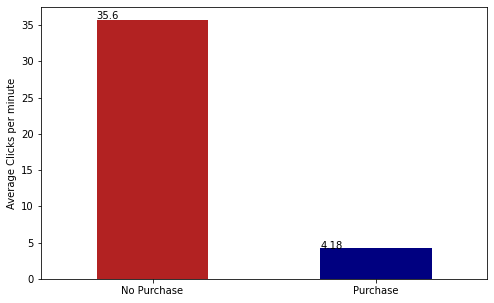

In [22]:
clicks_df_duration = clicks_df.copy().reset_index()
clicks_df_duration = clicks_df_duration.groupby('Session ID')['datetime'].agg(['first','last'])
clicks_df_duration['duration'] = (clicks_df_duration['last'] - clicks_df_duration['first']).dt.total_seconds()/60
clicks_df_duration = clicks_df_duration.reset_index()

clicks_df_clickrate = pd.merge(clicks_df_duration, clicks_df_tviews, how = 'inner', on = ['Session ID'])
clicks_df_clickrate['buys?'] = clicks_df_clickrate['Session ID'].apply(lambda x: 1 if x in sessions_buys else 0)
clicks_df_clickrate['click_rate_min'] = clicks_df_clickrate['Item ID']/clicks_df_clickrate['duration']
clicks_df_clickrate.replace([np.inf, -np.inf], np.nan, inplace=True)
clicks_df_clickrate_f = clicks_df_clickrate.groupby('buys?')['click_rate_min'].mean()
ax = clicks_df_clickrate_f.plot.bar(color = ['firebrick','navy'])
plt.ylabel('Average Clicks per minute')
plt.xlabel('')
#plt.title('Average Clicks per minute for each category')
plt.xticks((0,1), ('No Purchase', 'Purchase'), rotation = 0)
for p in ax.patches:
    ax.annotate(str(p.get_height())[:4], (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

#### Max and Mean Dwell Time

In [23]:
clicks_df_dwell = clicks_df.copy().reset_index()
clicks_df_dwell['prev'] = clicks_df_dwell.groupby('Session ID')['datetime'].transform(lambda x: x.shift())
clicks_df_dwell['diff_prev'] = clicks_df_dwell["datetime"] - clicks_df_dwell["prev"] 
clicks_df_dwell["dwell"] = clicks_df_dwell.groupby('Session ID')['diff_prev'].transform(lambda x: x.shift(-1)).dt.seconds/60
clicks_df_maxdwell = clicks_df_dwell.groupby('Session ID')['dwell'].max()
clicks_df_meandwell = clicks_df_dwell.groupby('Session ID')['dwell'].mean()

#### Most Viewed Item

In [24]:
clicks_df_mvi = clicks_df.copy()
clicks_df_mvi = clicks_df_mvi.groupby(['Session ID', 'Item ID'])['Item ID'].count() 
clicks_df_mvi = clicks_df_mvi.reset_index(name = 'count')
clicks_df_mvi = clicks_df_mvi.groupby('Session ID').max('count')
clicks_df_mvi.head()

,Item ID,count
Session ID,,
1,214577561,1
2,214825110,2
3,214832672,1
4,214836765,1
6,214826623,1


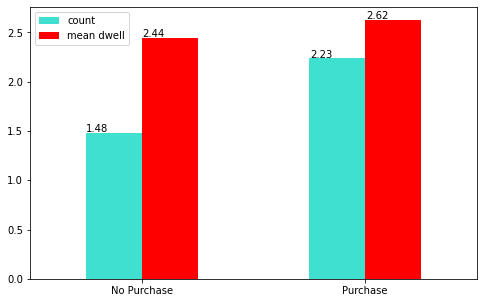

In [25]:
clicks_df_mvi2 = clicks_df_mvi.copy().reset_index()
clicks_df_mvi2['buy?'] = clicks_df_mvi2['Session ID'].apply(lambda x: 1 if x in sessions_buys else 0)
clicks_df_mvi2 = clicks_df_mvi2.groupby('buy?').mean()
clicks_df_mvi2['mean dwell'] = clicks_df_dwell.groupby('buy?')['dwell'].mean()
ax = clicks_df_mvi2.loc[:, ['count', 'mean dwell']].plot.bar(color = ['turquoise','red'])
plt.ylabel('')
plt.xlabel('')
#plt.title('Average Clicks per minute for each category')
plt.xticks((0,1), ('No Purchase', 'Purchase'), rotation = 0)
for p in ax.patches:
    ax.annotate(str(p.get_height())[:4], (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

## Feature Engineering

In [26]:
# Our aim here is to incorporate all the attributes analysed above and feed to the ML algorithm
# The first step is to create the temporal attribute as one table 
clicks_df_2 = pd.read_csv('/Users/macbookpro/Desktop/Digital Marketing Analytics/Assignments/Assignment 3/yoochoose-clicks.dat', 
                 encoding='Windows-1252', names=['Session ID','Timestamp','Item ID','Category'])

clicks_df_temp = clicks_df_2.copy()
clicks_df_temp['datetime'] = pd.to_datetime(clicks_df_temp['Timestamp'])
clicks_df_temp = clicks_df_temp.set_index('datetime')

def add_temporal_attributes(data):
    data['weekday'] = data.index.weekday
    data['hour'] = data.index.hour
    data['day'] = data.index.dayofyear
    data['month'] = data.index.month
    data['holidays name'] = pd.Series(data.index).apply(lambda x: uk_holidays.get(x)).values
    data['holidays name'] = data['holidays name'].fillna('no')
    data.loc[data['holidays name'].str.contains("St. Patrick's Day"), 'holidays name'] = 'no' 
    data['holidays'] = np.where(data['holidays name'] == 'no', 0, 1)
    data['buy?'] = data['Session ID'].apply(lambda x: 1 if x in sessions_buys else 0)
    return data

clicks_df_temp = add_temporal_attributes(clicks_df_temp)
clicks_df_temp = clicks_df_temp.groupby('Session ID').first()
clicks_df_temp = clicks_df_temp.drop('Item ID', axis = 1)
clicks_df_temp.head()

,Timestamp,Category,weekday,hour,day,month,holidays name,holidays,buy?
Session ID,,,,,,,,,
1,2014-04-07T10:51:09.277Z,0,0,10,97,4,no,0,0
2,2014-04-07T13:56:37.614Z,0,0,13,97,4,no,0,0
3,2014-04-02T13:17:46.940Z,0,2,13,92,4,no,0,0
4,2014-04-07T12:09:10.948Z,0,0,12,97,4,no,0,0
6,2014-04-06T16:58:20.848Z,0,6,16,96,4,no,0,0


In [27]:
# The second step is to create the statistical attributes
# session duration 
clicks_df_duration = clicks_df_2.copy()
clicks_df_duration['datetime'] = pd.to_datetime(clicks_df_duration['Timestamp'])
clicks_df_duration = clicks_df_duration.groupby('Session ID')['datetime'].agg(['first','last'])
clicks_df_duration['duration'] = round((clicks_df_duration['last'] - clicks_df_duration['first']).dt.total_seconds()/ 60.0,2)
clicks_df_duration = clicks_df_duration.loc[:, 'duration']
clicks_df_duration = clicks_df_duration.reset_index()

# total items viewed
clicks_df_items_t = clicks_df_2.copy()
clicks_df_items_t['datetime'] = pd.to_datetime(clicks_df_items_t['Timestamp'])
clicks_df_items_t = clicks_df_items_t.groupby('Session ID')['Item ID'].count()
clicks_df_items_t = clicks_df_items_t.reset_index()
clicks_df_items_t = clicks_df_items_t.rename(columns={clicks_df_items_t['Item ID'].name:'all_views'})

# unique items viewed
clicks_df_items_u = clicks_df_2.copy()
clicks_df_items_u['datetime'] = pd.to_datetime(clicks_df_items_u['Timestamp'])
clicks_df_items_u = clicks_df_items_u.groupby('Session ID')['Item ID'].nunique()
clicks_df_items_u = clicks_df_items_u.reset_index()
clicks_df_items_u = clicks_df_items_u.rename(columns={clicks_df_items_u['Item ID'].name:'unique_views'})

# Click rate
clicks_df_rate = pd.merge(clicks_df_items_t, clicks_df_duration, how = 'inner', on = ['Session ID'])
clicks_df_rate['click_rate_min'] = clicks_df_rate['all_views']/clicks_df_rate['duration']
clicks_df_rate.replace([np.inf, -np.inf], 0, inplace=True)

# Join all the stats attributes
clicks_df_stats = pd.merge(clicks_df_rate, clicks_df_items_u, how = 'inner', on = ['Session ID'])
clicks_df_stats.head()

,Session ID,all_views,duration,click_rate_min,unique_views
0,1,4,5.85,0.683761,4
1,2,6,5.99,1.001669,5
2,3,3,12.42,0.241546,3
3,4,2,17.24,0.116009,2
4,6,2,4.10,0.487805,2


In [28]:
# Join all the desired attributes (both temporal and statistics)
clicks_df_final = pd.merge(clicks_df_stats, clicks_df_temp, how = 'inner', on = ['Session ID'])
clicks_df_final['max_dwell'] = clicks_df_maxdwell
clicks_df_final['mean_dwell'] = clicks_df_meandwell
clicks_df_final['most_viewed'] = clicks_df_mvi['count']
clicks_df_final.replace([np.nan], 0, inplace=True)
clicks_df_final.head()

,Session ID,all_views,duration,click_rate_min,unique_views,Timestamp,Category,weekday,hour,day,month,holidays name,holidays,buy?,max_dwell,mean_dwell,most_viewed
0,1,4,5.85,0.683761,4,2014-04-07T10:51:09.277Z,0,0,10,97,4,no,0,0,0.000000,0.000000,0.0
1,2,6,5.99,1.001669,5,2014-04-07T13:56:37.614Z,0,0,13,97,4,no,0,0,3.000000,1.944444,1.0
2,3,3,12.42,0.241546,3,2014-04-02T13:17:46.940Z,0,2,13,92,4,no,0,0,1.966667,1.190000,2.0
3,4,2,17.24,0.116009,2,2014-04-07T12:09:10.948Z,0,0,12,97,4,no,0,0,8.250000,6.200000,1.0
4,6,2,4.10,0.487805,2,2014-04-06T16:58:20.848Z,0,6,16,96,4,no,0,0,17.233333,17.233333,1.0


## Feature Selection

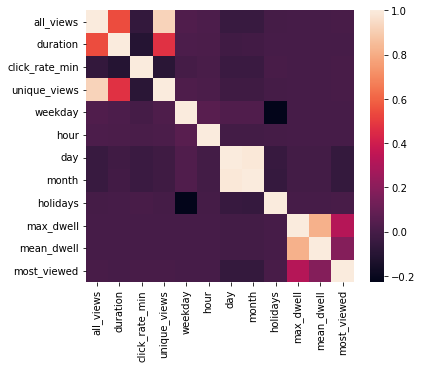

In [29]:
import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(clicks_df_final.loc[:, ['all_views','duration','click_rate_min','unique_views','weekday','hour','day','month','holidays','max_dwell','mean_dwell','most_viewed']].corr())
#plt.title('Visualising Multicollinearity between Attributes')
plt.show()

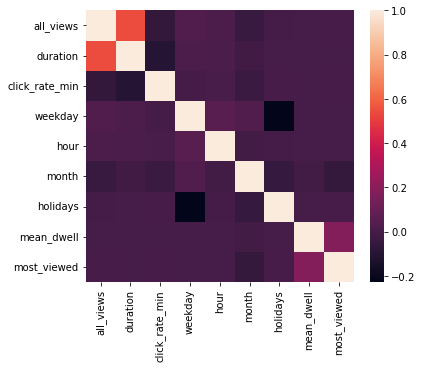

In [30]:
plt.figure(figsize=(6,5))
sns.heatmap(clicks_df_final.loc[:, ['all_views','duration','click_rate_min','weekday','hour','month','holidays','mean_dwell','most_viewed']].corr())
#plt.title('Visualising Multicollinearity between Attributes')
plt.show()

In [31]:
clicks_df_final['datetime'] = pd.to_datetime(clicks_df_final['Timestamp'])
clicks_df_final = clicks_df_final.sort_values(by=["datetime"])
y = clicks_df_final.loc[:, ['buy?']]
X = clicks_df_final.loc[:, ['all_views','duration','click_rate_min','unique_views','weekday','hour','day','month','holidays','max_dwell','mean_dwell','most_viewed']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 42, shuffle = False)

# apply oversampling
smote = SMOTE(random_state = 42)
X_train_ov, y_train_ov = smote.fit_resample(X_train, y_train.values.ravel())

print("Before applying the SMOTE oversampling technique, counts of label purchase: {}".format(sum(y_train.values.ravel() == 1)))
print("Before applying the SMOTE oversampling technique, counts of label no purchase: {} \n".format(sum(y_train.values.ravel() == 0)))
  
print("After applying the SMOTE oversampling technique, counts of label purchase: {}".format(sum(y_train_ov == 1)))
print("After applying the SMOTE oversampling technique, counts of label no purchase: {} \n".format(sum(y_train_ov == 0)))

# apply undersampling
nearmiss = NearMiss()
X_train_un, y_train_un = nearmiss.fit_resample(X_train, y_train.values.ravel())

print("After applying the Near Miss undersampling technique, counts of label purchase: {}".format(sum(y_train_un == 1)))
print("After applying the Near Miss undersampling technique, counts of label no purchase: {}".format(sum(y_train_un == 0)))

Before applying the SMOTE oversampling technique, counts of label purchase: 347737
Before applying the SMOTE oversampling technique, counts of label no purchase: 5818749 

After applying the SMOTE oversampling technique, counts of label purchase: 5818749
After applying the SMOTE oversampling technique, counts of label no purchase: 5818749 

After applying the Near Miss undersampling technique, counts of label purchase: 347737
After applying the Near Miss undersampling technique, counts of label no purchase: 347737


## Predictive Modelling (ML)

### Decision Tree Classifier

#### Oversampling

In [32]:
DTC = tree.DecisionTreeClassifier(random_state = 100)
DTC.fit(X_train_ov, y_train_ov)
y_pred_dtc1 = DTC.predict(X_test) 
print("The accuracy of the tree is", round(metrics.accuracy_score(y_test, y_pred_dtc1)*100,3),'%')

The accuracy of the tree is 83.687 %


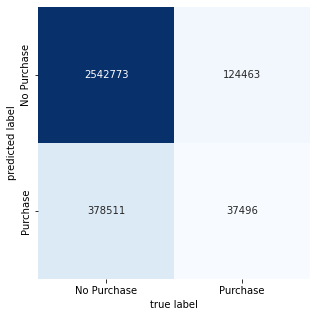

              precision    recall  f1-score   support

 No Purchase       0.95      0.87      0.91   2921284
    Purchase       0.09      0.23      0.13    161959

    accuracy                           0.84   3083243
   macro avg       0.52      0.55      0.52   3083243
weighted avg       0.91      0.84      0.87   3083243

The ROC AUC score of the tree is 55.097 %


In [33]:
fig, ax = plt.subplots(figsize=(5,5))
mat = confusion_matrix(y_test, y_pred_dtc1)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, xticklabels = ['No Purchase','Purchase'],
            yticklabels = ['No Purchase','Purchase'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
print(classification_report(y_test, y_pred_dtc1, target_names=['No Purchase','Purchase']))
print("The ROC AUC score of the tree is", round(roc_auc_score(y_test, y_pred_dtc1)*100,3),'%')

#### Undersampling

In [34]:
DTC = tree.DecisionTreeClassifier(random_state = 2)
DTC.fit(X_train_un, y_train_un)
y_pred_dtc2 = DTC.predict(X_test) 
print("The accuracy of the tree is", round(metrics.accuracy_score(y_test, y_pred_dtc2)*100,3),'%')

The accuracy of the tree is 32.785 %


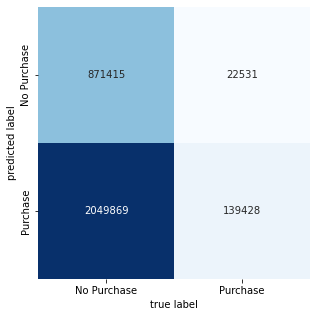

              precision    recall  f1-score   support

 No Purchase       0.97      0.30      0.46   2921284
    Purchase       0.06      0.86      0.12    161959

    accuracy                           0.33   3083243
   macro avg       0.52      0.58      0.29   3083243
weighted avg       0.93      0.33      0.44   3083243

The ROC AUC score of the tree is 57.959 %


In [35]:
fig, ax = plt.subplots(figsize=(5,5))
mat = confusion_matrix(y_test, y_pred_dtc2)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, xticklabels = ['No Purchase','Purchase'],
            yticklabels = ['No Purchase','Purchase'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
print(classification_report(y_test, y_pred_dtc2, target_names=['No Purchase','Purchase']))
print("The ROC AUC score of the tree is", round(roc_auc_score(y_test, y_pred_dtc2)*100,3),'%')

### Logistic Regression

#### Oversampling

In [69]:
X1 = clicks_df_final.loc[:, ['all_views','duration','click_rate_min','unique_views','weekday','hour','day','month','holidays','max_dwell','mean_dwell','most_viewed']]
X_s = StandardScaler().fit_transform(X1)
X_scaled = pd.DataFrame(X_s, columns=X1.columns)
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_scaled, y, test_size = 1/3, random_state = 42, shuffle = False)

smote = SMOTE(random_state = 42)
X_train_sc_ov, y_train_sc_ov = smote.fit_resample(X_train_sc, y_train_sc.values.ravel())

nearmiss = NearMiss()
X_train_sc_un, y_train_sc_un = nearmiss.fit_resample(X_train_sc, y_train_sc.values.ravel())

In [70]:
LR = LogisticRegression()
LR.fit(X_train_sc_ov, y_train_sc_ov)
y_pred_lr1 = LR.predict(X_test_sc)
print("The accuracy of the logistic regression is", round(metrics.accuracy_score(y_test_sc, y_pred_lr1)*100,3),'%')

The accuracy of the logistic regression is 78.603 %


              precision    recall  f1-score   support

 No Purchase       0.97      0.80      0.88   2921284
    Purchase       0.13      0.57      0.22    161959

    accuracy                           0.79   3083243
   macro avg       0.55      0.68      0.55   3083243
weighted avg       0.93      0.79      0.84   3083243

The ROC AUC score of the tree is 68.288 %


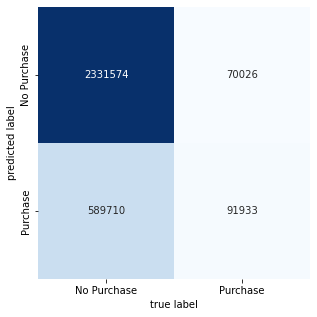

In [71]:
mat = confusion_matrix(y_test, y_pred_lr1)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, xticklabels = ['No Purchase','Purchase'],
            yticklabels = ['No Purchase','Purchase'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
print(classification_report(y_test_sc, y_pred_lr1, target_names=['No Purchase','Purchase']))
print("The ROC AUC score of the LR is", round(roc_auc_score(y_test_sc, y_pred_lr1)*100,3),'%')

#### Undersampling

In [72]:
LR = LogisticRegression()
LR.fit(X_train_sc_un, y_train_sc_un)
y_pred_lr2 = LR.predict(X_test_sc)
print("The accuracy of the logistic regression is", round(metrics.accuracy_score(y_test_sc, y_pred_lr2)*100,3),'%')

The accuracy of the logistic regression is 40.255 %


              precision    recall  f1-score   support

 No Purchase       0.98      0.38      0.55   2921284
    Purchase       0.07      0.85      0.13    161959

    accuracy                           0.40   3083243
   macro avg       0.52      0.61      0.34   3083243
weighted avg       0.93      0.40      0.52   3083243

The ROC AUC score of the tree is 61.336 %


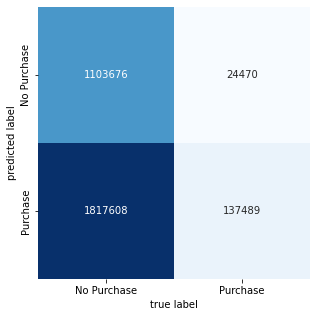

In [73]:
mat = confusion_matrix(y_test, y_pred_lr2)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, xticklabels = ['No Purchase','Purchase'],
            yticklabels = ['No Purchase','Purchase'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
print(classification_report(y_test_sc, y_pred_lr2, target_names=['No Purchase','Purchase']))
print("The ROC AUC score of the LR is", round(roc_auc_score(y_test, y_pred_lr2)*100,3),'%')

### Naïve Bayes Classifier

The accuracy of the Naive Bayes classifier is 91.187 %


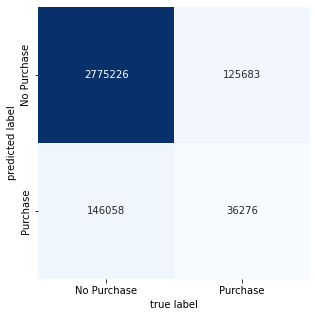

              precision    recall  f1-score   support

 No Purchase       0.96      0.95      0.95   2921284
    Purchase       0.20      0.22      0.21    161959

    accuracy                           0.91   3083243
   macro avg       0.58      0.59      0.58   3083243
weighted avg       0.92      0.91      0.91   3083243

The ROC AUC score of the tree is 58.699 %


In [41]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred_gnb = gnb.predict(X_test)
print("The accuracy of the Naive Bayes classifier is", round(metrics.accuracy_score(y_test, y_pred_gnb)*100,3),'%')

fig, ax = plt.subplots(figsize=(5,5))
mat = confusion_matrix(y_test, y_pred_gnb)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, xticklabels = ['No Purchase','Purchase'],
            yticklabels = ['No Purchase','Purchase'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
print(classification_report(y_test, y_pred_gnb, target_names=['No Purchase','Purchase']))
print("The ROC AUC score of the NB is", round(roc_auc_score(y_test, y_pred_gnb)*100,3),'%')

The accuracy of the Naive Bayes classifier is 84.653 %


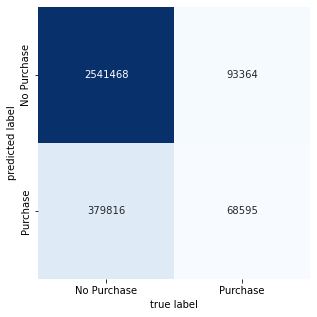

              precision    recall  f1-score   support

 No Purchase       0.96      0.87      0.91   2921284
    Purchase       0.15      0.42      0.22    161959

    accuracy                           0.85   3083243
   macro avg       0.56      0.65      0.57   3083243
weighted avg       0.92      0.85      0.88   3083243

The ROC AUC score of the tree is 64.676 %


In [53]:
gnb = GaussianNB()
gnb.fit(X_train_ov, y_train_ov)

y_pred_gnb = gnb.predict(X_test)
print("The accuracy of the Naive Bayes classifier is", round(metrics.accuracy_score(y_test, y_pred_gnb)*100,3),'%')

fig, ax = plt.subplots(figsize=(5,5))
mat = confusion_matrix(y_test, y_pred_gnb)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, xticklabels = ['No Purchase','Purchase'],
            yticklabels = ['No Purchase','Purchase'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
print(classification_report(y_test, y_pred_gnb, target_names=['No Purchase','Purchase']))
print("The ROC AUC score of the NB is", round(roc_auc_score(y_test, y_pred_gnb)*100,3),'%')

### Predicting items

In [42]:
clicks_df_dwell['primary_id'] = clicks_df_dwell["Session ID"].astype(str) +"_"+ clicks_df_dwell["Item ID"].astype(str)
clicks_df_dwell2 = clicks_df_dwell.copy()
clicks_df_dwell2 = clicks_df_dwell2.groupby('primary_id').sum('dwell')

In [43]:
buys_df['primary_id'] = buys_df["Session ID"].astype(str) +"_"+ buys_df["Item ID"].astype(str)

items_bought = set()
for i in buys_df['primary_id']:
    items_bought.add(i)

buys_event = clicks_df.copy().reset_index()
buys_event['primary_id'] = buys_event["Session ID"].astype(str) +"_"+ buys_event["Item ID"].astype(str)
buys_event_final = buys_event.groupby('primary_id').agg({'primary_id': 'count', 'month': 'first', 'hour': 'first', \
                                                 'weekday': 'first', })
buys_event_final['dwell'] = clicks_df_dwell2["dwell"]
buys_event_final = buys_event_final.rename(columns={'primary_id': 'total_clicks'})
buys_event_final = buys_event_final.reset_index()
buys_event_final.head()

,primary_id,total_clicks,month,hour,weekday,dwell
0,10000001_214556212,1,9,10,0,0.583333
1,10000001_214556216,1,9,10,0,0.266667
2,10000001_214854125,1,9,10,0,0.000000
3,10000001_214854230,2,9,10,0,12.033333
4,10000002_214714721,1,9,19,0,18.716667


In [44]:
item_popularity = clicks_df.copy().reset_index()
item_popularity = item_popularity.groupby('Item ID')['Session ID'].count().reset_index()
item_popularity['item'] = item_popularity['Item ID'].astype(str)
item_popularity = item_popularity.rename(columns={'Session ID': 'popularity'})
item_popularity = item_popularity.set_index('item').drop('Item ID', axis = 1)
dict_popularity = item_popularity.T.to_dict('list')

In [45]:
buys_event_final['popularity'] = buys_event_final['primary_id'].apply(lambda x: dict_popularity[str(x[-9:])][0] 
                                                                      if str(x[-10:])[0] == '_'
                                                                      else dict_popularity[str(x[-10:])][0]) 
buys_event_final['bought'] = buys_event_final['primary_id'].apply(lambda x: 1 if x in items_bought else 0)

In [46]:
sessions_buys2 = set()
for i in buys_df['Session ID']:
    sessions_buys2.add(str(i))
    
buys_event_final['buy?'] = buys_event_final['primary_id'].apply(lambda x: 1 if x[:x.find('_')] in sessions_buys2 else 0)

In [47]:
buys_event_final2 = buys_event_final[buys_event_final['buy?'] == 1]
buys_event_final2

,primary_id,total_clicks,month,hour,weekday,dwell,popularity,bought,buy?
11,10000004_214851326,3,9,13,4,2.516667,46095,1,1
12,10000004_214853090,3,9,13,4,41.216667,46866,1,1
13,10000004_214853094,1,9,14,4,6.600000,125690,0,1
14,10000004_214853248,1,9,13,4,1.566667,30379,0,1
67,10000024_214510445,1,9,7,6,37.583333,28310,1,1
...,...,...,...,...,...,...,...,...,...
26615388,9999943_214854122,1,9,12,6,0.916667,6684,0,1
26615389,9999943_214854547,1,9,12,6,0.000000,16403,0,1
26615432,9999959_214846254,1,9,16,0,0.000000,6099,1,1
26615544,9999991_214531138,1,9,10,4,0.900000,198,0,1


In [114]:
y2 = buys_event_final2.loc[:, ['bought']]
X2 = buys_event_final2.loc[:, ['total_clicks','month','hour','weekday','dwell','popularity']]
X_s = StandardScaler().fit_transform(X2)
X_scaled2 = pd.DataFrame(X_s, columns=X2.columns)
X_train_sc2, X_test_sc2, y_train_sc2, y_test_sc2 = train_test_split(X_scaled2, y2, test_size = 1/3, random_state = 42, shuffle = False)

LR2 = LogisticRegression()
LR2.fit(X_train_sc2, y_train_sc2)
y_pred_lr3 = LR2.predict(X_test_sc2)
print("The accuracy of the logistic regression is", round(metrics.accuracy_score(y_test_sc2, y_pred_lr3)*100,3),'%')

The accuracy of the logistic regression is 64.787 %


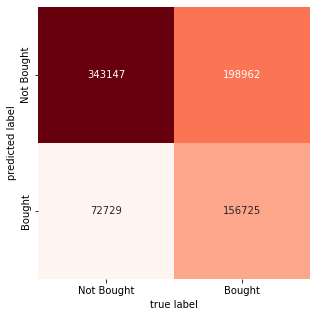

              precision    recall  f1-score   support

  Not Bought       0.63      0.83      0.72    415876
      Bought       0.68      0.44      0.54    355687

    accuracy                           0.65    771563
   macro avg       0.66      0.63      0.63    771563
weighted avg       0.66      0.65      0.63    771563

The ROC AUC score of the logistic regression is 63.287 %


In [115]:
mat = confusion_matrix(y_test2, y_pred_lr3)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, xticklabels = ['Not Bought','Bought'],
            yticklabels = ['Not Bought','Bought'], cmap="Reds")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
print(classification_report(y_test2, y_pred_lr3, target_names=['Not Bought','Bought']))
print("The ROC AUC score of the logistic regression is", round(roc_auc_score(y_test2, y_pred_lr3)*100,3),'%')

### Evaluation Metric

In [153]:
y = clicks_df_final.loc[:, ['buy?']]
X = clicks_df_final.loc[:, ['all_views','duration','click_rate_min','unique_views','weekday','hour','day','month', \
                            'holidays','max_dwell','mean_dwell','most_viewed', 'Session ID']]
X = X.set_index('Session ID')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 42, shuffle = False)
LR1 = LogisticRegression()
LR1.fit(X_train_sc_ov, y_train_sc_ov)

LogisticRegression()

In [154]:
def evaluation_metric(X_train_sc_ov, y_train_sc_ov, X_test, y_test):
    score = 0
    y_pred_lr = LR1.predict(X_test)
    print('Session predicitons done')
    X_test['y_pred'] = y_pred_lr
    X_test['y_true'] = y_test.values.ravel()
    predicted_session = list(X_test[X_test.y_pred == 1].index.astype(str))
    
    print('Items predictions for all sessions predicted as 1 initialised')
    # all sessions predicted as purchased (not included in scoring performance)
    #buys_event_final['predicted'] = buys_event_final['primary_id'].apply(lambda x: 1 if x[:x.find('_')] in predicted_session else 0)
    #df2 = buys_event_final[buys_event_final['predicted'] == 1]
    #df2 = df2.set_index('primary_id')
    #y_test2 = df2.loc[:, ['bought']]
    #X2 = df2.loc[:, ['total_clicks','month','hour','weekday','dwell','popularity']]
    #X_s = StandardScaler().fit_transform(X2)
    #X_test2 = pd.DataFrame(X_s, columns=X2.columns)
    #y_pred2 = LR2.predict(X_test2)
    #X2['bought'] = y_test2.values.ravel()
    #X2['prediction'] = y_pred2
    #X2.to_csv('prediction_items_csv.csv')
    #X_test.to_csv('prediction_sessions_csv.csv')
    print('Items prediction saved')
    print('Sessions predictions saved')
    
    print('Items predictions for only sessions predicted and originally labelled as 1 initialised')
    # only sessions predicted and originally labelled as purchased (inluded in scoring performance)
    buys_event_final2['predicted'] = buys_event_final2['primary_id'].apply(lambda x: 1 if x[:x.find('_')] in predicted_session else 0)
    df3 = buys_event_final2[buys_event_final2['predicted'] == 1]
    df3 = df3.set_index('primary_id')
    y_test3 = df3.loc[:, ['bought']]
    X3 = df3.loc[:, ['total_clicks','month','hour','weekday','dwell','popularity']]
    X_s = StandardScaler().fit_transform(X3)
    X_test3 = pd.DataFrame(X_s, columns=X3.columns)
    print('Items predicitons done')
    y_pred3 = LR2.predict(X_test3)
    X3['B_s'] = y_test3.values.ravel()
    X3['A_s'] = y_pred3
    X3['A_s ∩ B_s'] = -abs(X3['B_s'] - X3['A_s']) + 1
    X3['A_s ∪ B_s'] = X3.apply(lambda x: x['A_s'] if  x['A_s'] == x['B_s'] == 0 else 1, axis = 1)
    X3 = X3.reset_index()
    X3['Session ID'] = X3['primary_id'].apply(lambda x: x[:x.find('_')])
    X4 = X3.groupby('Session ID')['A_s ∩ B_s', 'A_s ∪ B_s'].sum()
    X4 = X4.reset_index()
    X4['score'] = X4['A_s ∩ B_s']/X4['A_s ∪ B_s']
    jaccard = sum(X4['score'])
    print('Jaccard score computed')
    
    S_b = sum(y_test['buy?'] == 1)
    S = len(y_test)
    
    print('Calculating sessions score')
    for i,j in zip(y_pred_lr,y_test.values.ravel()):
        if i == j == 1:
            score += (S_b/S)
        elif i == 1 and j == 0:
            score += (S_b/S)
    print('Returning overall score')
    
    return score + jaccard
        
evaluation_metric(X_train_sc_ov, y_train_sc_ov, X_test, y_test)

Session predicitons done
Items predictions for all sessions predicted as 1 initialised
Items prediction saved
Sessions predictions saved
Items predictions for only sessions predicted and originally labelled as 1 initialised
Items predicitons done
Jaccard score computed
Calculating sessions score
Returning overall score


2213.5710787050066